In [16]:
!pip install -r requirements.txt

In [17]:
import re
import os
import gc
import math
import glob
import nltk
import shutil
import numpy as np
from os import listdir
from zipfile import ZipFile
from collections import Counter
import matplotlib.pyplot as plt
from os.path import isfile, join
from scipy.sparse import csc_matrix
from collections import defaultdict
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords as stopWords
from nltk.tokenize import word_tokenize as wordTokenize

In [18]:
np.seterr('raise')

nltk.download('punkt')
nltk.download('stopwords')

stopWordsSet = set(stopWords.words('english'))
ps = PorterStemmer()

[nltk_data] Downloading package punkt to /home/henriq/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/henriq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

In [20]:
class Node:
    def __init__(self, docId, freq):
        self.freq = freq
        self.doc = docId
        self.next = None
    
    def __str__(self):        
        return 'doc:' + str(self.doc) + ', freq:' + str(self.freq)

class LinkedList:
    def __init__(self):
        self.head = None
        self.tail = None
        self.n_docs = 0
    
    def print_list(self):
        aux = self.head
        while aux:
            print(aux)
            aux = aux.next
    
    def get_doclist(self):
        l = []
        aux = self.head
        while aux:
            l.append([aux.doc, aux.freq])
            aux = aux.next
        return l
    
    def add_doc(self, doc, freq):
        node = Node(doc, freq)        
        if self.head == None:
            self.head = node        
        else:
            self.tail.next = node
        self.tail = node
        self.n_docs += 1

In [21]:
def removeSpecialCharacters(text):
    regex = re.compile('[^a-zA-Z0-9\s]')
    return re.sub(regex, '', text)

def tokenizeAndRemoveSpecialCharacters(text):
    return wordTokenize(removeSpecialCharacters(text))

def listsIntersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def computeNorm(word, maxFreq, linkedListData, wordsInDocument, itf, docsIds):
    sum = 0
    docs = linkedListData[word].get_doclist()

    for doc in wordsInDocument.keys():
        if doc in docs:
            freq = docs[1]
        else:
            freq = 0
        a = pow((0.5 + 0.5 * (freq / maxFreq)), 2)
        b = pow(itf[docsIds[doc]], 2)
        sum = sum + a * b

    return math.sqrt(sum)

def getMaxFreq(word, linkedListData):
    maxFreq = 0
    docs = linkedListData[word].get_doclist()

    for doc in docs:
        freq = doc[1]
        if freq > maxFreq:
            maxFreq = freq
    return maxFreq

def getFileText(text):
    try:
        text = re.search('<TEXT>(.+?)</TEXT>', text, flags=re.DOTALL).group(1)
    except AttributeError: # <TEXT></TEXT> not found in the original string
        text = ''
    return text

def getFileName(text):
    try:
        name = re.search('<DOCNO>(.+?)</DOCNO>', text, flags=re.DOTALL).group(1)
    except AttributeError: # <DOCNO></DOCNO> not found in the original string
        name = ''
    return name

def filterText(removeStopWords, removeStemmingWords, value):
    words = []
    for w in value:
        if removeStopWords == True and w not in stopWordsSet: # stop words
            if removeStemmingWords == True:
                w = ps.stem(w)  # stemming
        elif removeStopWords == False:
            if removeStemmingWords == True:
                w = ps.stem(w)  # stemming
        words.append(w)
    return words

def readDocs(path):
    numDocs = 0
    docsIds = {}
    docsNames = []
    wordsInDocument = {}

    for folder in glob.glob(path):
        for subfolder in glob.glob(folder + '/*'):
            for directory in glob.glob(subfolder + '/*'):
                for subdir in glob.glob(directory):
                    with open(subdir, "r") as doc:
                        text = doc.read()
                        
                        fileName = getFileName(text)
                        
                        wordsInDocument[fileName] = getFileText(text)
                        
                        wordsInDocument[fileName] = tokenizeAndRemoveSpecialCharacters(wordsInDocument[fileName].lower())
                        
                        # atribuindo um id pra cada documento
                        docsIds[fileName] = numDocs

                        # salvando nomes dos arquivos
                        docsNames.append(fileName)
                        
                        numDocs = numDocs + 1
                doc.close()

    return numDocs, docsIds, docsNames, wordsInDocument

def readQueriesDoc(path):
    """Lê o documento en.topics e armazena as queries, e seus respectivos ids, que serão usados"""

    queries = defaultdict()
    with open(path) as file:
        text = file.read()
        splitted = text.split("\n\n")

    for line in splitted:
        if 'topics' in line: continue
        id = re.search(r'<num>(.*?)</num>', line).group(1)
        query = re.search(r'<title>(.*?)</title>.', line, flags=re.DOTALL).group(1)
        query += re.search(r'<narr>(.*?)</narr>', line, flags=re.DOTALL).group(1)
        query = removeSpecialCharacters(query)
        queries[id] = wordTokenize(query)
        queries[id] = filterText(True, True, queries[id])

    return queries

def prob_model(wordsInDocument, query, linkedListData, numDocs, uniqueWords):
    """
    Modelo probabilistico
    """

    # Seleção inicial
    initial_sel_answer = {}
    
    for doc in wordsInDocument.keys():
        words = wordsInDocument[doc]
        commonWordsBetweenQueryAndDoc = listsIntersection(query, words)
        relevance = 0
        for ki in commonWordsBetweenQueryAndDoc:
            numDocsWithKi = linkedListData[ki].n_docs
            relevance += math.log10((numDocs + 0.5)/(numDocsWithKi + 0.5))
            if relevance > 0:
                initial_sel_answer[doc] = relevance
    
    # verifica qual a maior relevancia encontrada
    # na seleção inicial dentre os documentos
    max = 0
    doc = ''
    for item in initial_sel_answer.keys():
        if initial_sel_answer[item] > max:
            max = initial_sel_answer[item]
            doc = item
            
    # Ranqueamento final

    relevantDocs = []
    numRelevantDocs = {}
    
    sorted_answer = sorted(initial_sel_answer.items(), key = lambda x: x[1], reverse = True)

    relevantDocs.append(sorted_answer[0][0])
    
    final_rank_answer = {}
    
    for word in query:
        if word not in uniqueWords:
            continue
        postings = linkedListData[word].head
        numRelevantDocs[word] = 0
        while postings:
            if postings.doc in relevantDocs:
                numRelevantDocs[word] += 1
            postings = postings.next
    
    numRelevantDocsToQuery = len(relevantDocs)
    
    for doc in wordsInDocument.keys():
        words = wordsInDocument[doc]
        commonWordsBetweenQueryAndDoc = listsIntersection(query, words)
        relevance = 0
    
        for ki in commonWordsBetweenQueryAndDoc:
            numDocsWithKi = linkedListData[ki].n_docs
            numRelevantDocsWithKi = numRelevantDocs[ki]
            
            numerator = ((numRelevantDocsWithKi + 0.5) * (numDocs - numDocsWithKi - numRelevantDocsToQuery + numRelevantDocsWithKi + 0.5))

            denominator = ((numRelevantDocsToQuery - numRelevantDocsWithKi + 0.5) * (numDocsWithKi - numRelevantDocsWithKi + 0.5))

            if numerator <= 0 or denominator <= 0: relevance += 0
            else: relevance += math.log10(numerator / denominator)

        final_rank_answer[doc] = relevance

    # final_rank_answer

    # Se os dois prints tiverem o mesmo valor, significa que
    # o documento com mais relevância na seleção inicial
    # é o mesmo na seleção final

    # max = 0
    # for item in final_rank_answer.keys():
    #     if final_rank_answer[item] > max:
    #         max = final_rank_answer[item]

    # if final_rank_answer[relevantDocs[0]] == max:
    #     print("\nResultados iguais = ", final_rank_answer[relevantDocs[0]])

    return initial_sel_answer, final_rank_answer

def vect_model(wordsIds, uniqueWords, numDocs, linkedListData, query, docsNames, docsIds):
    """
    Modelo Vetorial

    Iremos utilizar a ponderação de termos TF-IDF, que considera a frequência de cada termo e a frequência inversa de documento.

    Alguns termos possuem maior importância semântica para representar determinado elemento. Por exemplo, um termo que aparece em todos os documentos indexados não nos auxilia em nada no rankeamento dos mesmos, da mesma forma que um termo raro pode ser de extrema importância para identificar um determinado assunto.

    """
    # Ponderação TF-IDF

    m = np.zeros((len(uniqueWords), numDocs))
    
    for word in uniqueWords:
        postings = linkedListData[word].get_doclist()
        
        idf = math.log2(numDocs/ linkedListData[word].n_docs)
    
        for node in postings:
    
            docName = node[0]
            freq = node[1]
    
            # tf-idf = (1+log2(freq))*idf, se freq > 0
            if freq > 0:
              m[wordsIds[word], docsIds[docName]] = (1 + math.log2(freq)) * idf
            # tf-idf = 0, caso contrario
            #   m[wordsIds[word], docsIds[docName]] = 0

    """Normalização pelo tamanho dos documentos"""
    m = m**2
    norm = np.sum(m, axis=0)
    norm = [math.sqrt(norm[i]) for i in range(len(norm))]

    """Realizando a ponderação TF-IDF na query"""

    i = 0
    queryVector = np.zeros(len(uniqueWords))
    
    for word in uniqueWords:
        if word in query:
            idf = math.log2(numDocs/ linkedListData[word].n_docs)
            queryVector[i] = (1 + math.log2(query.count(word))) * idf
            i += 1

    """Ranqueamento"""
    
    ranking = {}
    
    for docName in docsNames:
        ranking[docName] = np.dot(m[:,docsIds[docName]], queryVector) / norm[docsIds[docName]]
    
    sorted_ranking = {k: v for k, v in sorted(ranking.items(), key = lambda item: item[1], reverse=True)}

    del m
    gc.collect()

    return sorted_ranking

def query_expansion(numDocs, wordsInDocument, docsIds, uniqueWords, linkedListData, query, wordsIds):
    """
    Expansão de consultas

    """
    
    """Frequência inversa de termo (itf)"""

    # Frequencia inversa de termo (itf) pra cada documento j
    # Calculo dele é dado por:
    # numerador = nro de termos distintos em tds os docs
    # denominador = nro de termos distintos no doc j
    # itf(doc j) = numerador / denominador
    itf = [0] * numDocs

    for doc in wordsInDocument.keys():
        uniqueWordsInDoc = set(wordsInDocument[doc])
        if(len(uniqueWordsInDoc) == 0): 
            continue
        docId = docsIds[doc]
        itf[docId] = math.log2(len(uniqueWords) / len(uniqueWordsInDoc))

    """Pesagem dos documentos"""

    w = np.zeros((len(uniqueWords), numDocs))
    
    for word in uniqueWords:
        maxFreq = getMaxFreq(word, linkedListData)
        norm = computeNorm(word, maxFreq, linkedListData, wordsInDocument, itf, docsIds)
    
        for docs in linkedListData[word].get_doclist():
            fileName = docs[0]
            freq = docs[1]
            a = (0.5 + 0.5 * (freq / maxFreq))
            b = itf[docsIds[fileName]]
            w[wordsIds[word]][docsIds[fileName]] = (a * b) / norm

    """Similaridade"""

    # Similaridade
    c = np.dot(w, w.transpose())

    del w
    gc.collect()

    """Pesagem da consulta"""

    # Pesagem da consulta
    q = [0] * len(query)
    
    uniqueWordsInQuery = set(query)
    
    i = 0
    wordsInQueryIds = {}
    for word in query:
        wordsInQueryIds[word] = i
        i = i + 1
    
    sum = 0
    for i in range(len(itf)):
        sum = sum + math.pow(itf[i], 2)
    norm = math.sqrt(sum)
    
    for word in query:
        q[wordsInQueryIds[word]] = math.log2(len(uniqueWords)/ len(uniqueWordsInQuery)) / norm

    """Combinação da similaridade com pesagem da consulta"""

    result = {}
    
    # Combinação da similaridade com a pesagem da consulta
    for word in uniqueWords:
        similaridade = 0
        result[word] = similaridade
        for item in query:
            a = q[wordsInQueryIds[item]]
            if item not in uniqueWords:
                b = 0
            else:
                b = c[wordsIds[item]][wordsIds[word]]
            similaridade = similaridade + a * b
            result[word] = similaridade

    """Resultado da expansão"""

    sorted_result = {k: v for k, v in sorted(result.items(), key = lambda item: item[1], reverse=True)}

    keys = list(sorted_result.keys())

    return sorted_result

def getRelDocs(path):
    rel_docs = defaultdict()

    with open(path) as file:
        for line in file:
            token = wordTokenize(line)
            if token[3] == '1':
                if int(token[0]) in rel_docs.keys():
                    rel_docs[int(token[0])].append(token[2])
                else:
                    rel_docs[int(token[0])] = [token[2]]

    return rel_docs

def evaluation(queryId, rel_docs, answer, recall_I):
    """
    Avaliação
    
    A avaliação serve para julgar o quão bem o sistema atende à necessidade de 
    informação do usuário. Estamos considerando precisão e revocação. 
    """

    intersec = 0
    acessedDocs = 0
    precisaoList = []
    revocacaoList = []
    queryId = int(queryId)

    for rel_doc in answer.keys():
        acessedDocs += 1
        if rel_doc in rel_docs:
            intersec += 1
            precisaoList.append(intersec/acessedDocs)
            revocacaoList.append(intersec/len(rel_docs))

    if len(revocacaoList) == 0 or len(precisaoList) == 0:
        revocacaoList.append(0)
        precisaoList.append(0)

    precision_I = np.interp(recall_I, revocacaoList, precisaoList)

    return precision_I

def median(precision):
    med = np.zeros(11)
    tam = 0
    for prec in precision.keys():        
        med += precision[prec]
        tam +=1
    med = med/tam

    return med

In [22]:
%%time

docsPath = 'a/*'
topicsPath = 'en.topics.76-125.2010.txt'
queriesPath = 'en.qrels.76-125.2010.txt'

numDocs, docsIds, docsNames, wordsInDocument = readDocs(docsPath)

CPU times: user 34.2 ms, sys: 0 ns, total: 34.2 ms
Wall time: 34.2 ms


In [23]:
%%time

dict = defaultdict(int)

# Remoção de stopwords, radicalização e indexação
for key, value in wordsInDocument.items():
  wordsInDocument[key] = filterText(True, True, value)

CPU times: user 87.6 ms, sys: 0 ns, total: 87.6 ms
Wall time: 87.4 ms


In [24]:
%%time

for key, value in wordsInDocument.items():
  for w in set(value): 
    dict[w] += 1

CPU times: user 1.64 ms, sys: 0 ns, total: 1.64 ms
Wall time: 1.65 ms


In [25]:
%%time

i = 0
wordsIds = {}
linkedListData = {}
uniqueWords = sorted(set(dict.keys()))

# atribuindo um id pra cada palavra
for word in uniqueWords:
    wordsIds[word] = i
    linkedListData[word] = LinkedList()
    i = i + 1

print("\nFound %d unique words" % len(uniqueWords))

for doc in wordsInDocument.keys():
    words = wordsInDocument[doc]
    for word in set(words):
        linkedListData[word].add_doc(doc, words.count(word))


Found 2571 unique words
CPU times: user 53 ms, sys: 119 µs, total: 53.2 ms
Wall time: 51.7 ms


In [26]:
%%time

print("\nFound %d unique words" % len(uniqueWords))

for doc in wordsInDocument.keys():
  words = wordsInDocument[doc]
  for word in set(words):
    linkedListData[word].add_doc(doc, words.count(word))


Found 2571 unique words
CPU times: user 50.5 ms, sys: 0 ns, total: 50.5 ms
Wall time: 49.4 ms


In [27]:
%%time

queries = readQueriesDoc(topicsPath)
rel_docs = getRelDocs(queriesPath)

initial_sel_answer = defaultdict()
final_rank_answer = defaultdict()

ranked_vect_answer = defaultdict()

expansion_answer = defaultdict()
precisionProb = defaultdict()
precisionVet = defaultdict()

recall = np.linspace(0, 1, num=11, endpoint=True)

CPU times: user 1.34 s, sys: 2.23 ms, total: 1.34 s
Wall time: 1.34 s


In [30]:
%%time

# Define qual query iremos trabalhar em cima
for queryId in queries.keys():
    query = queries[queryId]

    initial_sel_answer[queryId], final_rank_answer[queryId] = prob_model(wordsInDocument, query, linkedListData, numDocs, uniqueWords)

    ranked_vect_answer[queryId] = vect_model(wordsIds, uniqueWords, numDocs, linkedListData, query, docsNames, docsIds)

    # expansion_answer[queryId] = query_expansion(numDocs, wordsInDocument, docsIds, uniqueWords, linkedListData, query, wordsIds)

    precisionProb[queryId] = evaluation(queryId, rel_docs[int(queryId)], initial_sel_answer[queryId], recall)

    precisionVet[queryId] = evaluation(queryId, rel_docs[int(queryId)], ranked_vect_answer[queryId], recall)

precisionProbMedian = median(precisionProb)
precisionVetMedian = median(precisionVet)

CPU times: user 3.12 s, sys: 0 ns, total: 3.12 s
Wall time: 3.14 s


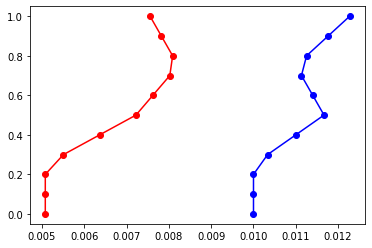

In [32]:
plt.plot(recall, precisionProbMedian, linestyle='-', marker='o', color='b')
plt.plot(recall, precisionVetMedian, linestyle='-', marker='o', color='r')
plt.show()